In [1]:
import gc
import os
import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [3]:
tfsim.utils.tf_cap_memory()

In [4]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [5]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.8.2
TensorFlow Similarity 0.16.7


## Data preparation

We are going to load the MNIST dataset and restrict our training data to **only N of the 10 classes** (6 by default) to showcase how the model is able to find similar examples from classes unseen during training. The model's ability to generalize the matching to unseen classes, without retraining, is one of the main reason you would want to use metric learning.


**WARNING**: Tensorflow similarity expects `y_train` to be an IntTensor containing the class ids for each example instead of the standard categorical encoding traditionally used for multi-class classification.

In [6]:
from skimage import io


def prepare(path, array):
    for folder in os.listdir(path):
        sub_path = path + "/" + folder
        for img in os.listdir(sub_path):
            image_path = sub_path + "/" + img
            img_arr = io.imread(image_path)
            array.append(img_arr)


train_path = "./test"
valid_path = "./valid/"

train_x = []
valid_x = []

prepare(train_path, train_x)
prepare(valid_path, valid_x)



In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_gen = datagen.flow_from_directory(train_path)
valid_gen = datagen.flow_from_directory(valid_path)
train_y = train_gen.classes
valid_y = valid_gen.classes

Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


*For* a similarity model to learn efficiently, each batch must contains at least 2 examples of each class.

To make this easy, tf_similarity offers `Samplers()` that enable you to set both the number of classes and the minimum number of examples of each class per batch. Here we are creating a `MultiShotMemorySampler()` which allows you to sample an in-memory dataset and provides multiple examples per class.

TensorFlow Similarity provides various samplers to accomodate different requirements, including a `SingleShotMemorySampler()` for single-shot learning, a `TFDatasetMultiShotMemorySampler()` that integrate directly with the TensorFlow datasets catalogue, and a `TFRecordDatasetSampler()` that allows you to sample from very large datasets stored on disk as TFRecords shards.

In [8]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
           30, 31]
NUM_CLASSES = 32  # @param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = NUM_CLASSES
EXAMPLES_PER_CLASS = 5  # @param {type:"integer"}
STEPS_PER_EPOCH = 50  # @param {type:"integer"}

sampler = tfsim.samplers.MultiShotMemorySampler(
    train_x,
    train_y,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],  # Only use the first 6 classes for training.
    steps_per_epoch=STEPS_PER_EPOCH,

)


The initial batch size is 160 (32 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/2000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/160 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/160 [00:00<?, ?it/s]

## Model setup

### Model definition

`SimilarityModel()` models extend `tensorflow.keras.model.Model` with additional features and functionality that allow you to index and search for similar looking examples.

As visible in the model definition below, similarity models output a 64 dimensional float embedding using the `MetricEmbedding()` layers. This layer is a Dense layer with L2 normalization. Thanks to the loss, the model learns to minimize the distance between similar examples and maximize the distance between dissimilar examples. As a result, the distance between examples in the embedding space is meaningful; the smaller the distance the more similar the examples are. 

Being able to use a distance as a meaningful proxy for how similar two examples are, is what enables the fast ANN (aproximate nearest neighbor) search. Using a sub-linear ANN search instead of a standard quadratic NN search is what allows deep similarity search to scale to millions of items. The built in memory index used in this notebook scales to a million indexed examples very easily... if you have enough RAM :)

In [9]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)


model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                  

### Loss definition

Overall what makes Metric losses different from tradional losses is that:
- **They expect different inputs.** Instead of having the prediction equal the true values, they expect embeddings as `y_preds` and the id (as an int32) of the class as `y_true`. 
- **They require a distance.** You need to specify which `distance` function to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.

In this example we are using the `MultiSimilarityLoss()`. This loss takes a weighted combination of all valid positive and negative pairs, making it one of the best loss that you can use for similarity training.

In [10]:
distance = "L2"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)

### Compilation

Tensorflow similarity use an extended `compile()` method that allows you to optionally specify `distance_metrics` (metrics that are computed over the distance between the embeddings), and the distance to use for the indexer.

By default the `compile()` method tries to infer what type of distance you are using by looking at the first loss specified. If you use multiple losses, and the distance loss is not the first one, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [14]:
LR = 0.001  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)

Distance metric automatically set to euclidean use the distance arg to override.


## Training

Similarity models are trained like normal models. 

**NOTE**: don't expect the validation loss to decrease too much here because we only use a subset of the classes within the train data but include all classes in the validation data.

In [15]:
EPOCHS = 1  # @param {type:"integer"}

history = model.fit(sampler, epochs=EPOCHS)

50/50 [==============================] - 532s 11s/step - loss: 0.0000e+00


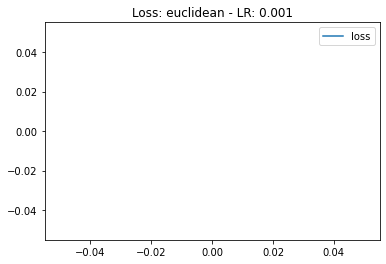

In [16]:
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.legend(["loss"])
plt.title(f"Loss: {loss.distance} - LR: {LR}")
plt.show()

## Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position within the learned metric space, we need a way to find which known example(s) are the closest to determine the class of the query example (aka nearest neighbors classication).

To do so, **we are creating an index of known examples from all the classes present in the dataset**. We do this by taking a total of **200 examples from the train dataset which amount to 20 examples per class** and we use the `index()` method of the model to build the index.

we store the images (x_index) as data in the index `(data=x_index)` so that we can display them later. Here the images are small so its not an issue but in general, be careful while storing a lot of data in the index to avoid blewing up your memory. You might consider using a different `Store()` backend if you have to store and serve very large indexes.

Indexing more examples per class will help increase the accuracy/generalization, as having more variations improves the classifier "knowledge" of what variations to expect. 

Reseting the index is not needed for the first run; however we always calling it to ensure we start the evaluation with a clean index in case of a partial re-run.

In [17]:
x_index, y_index = tfsim.samplers.select_examples(train_x, train_y, CLASSES, 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/2000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/640 [00:00<?, ?it/s]

[Indexing 640 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## Querying

To "classify" examples, we need to lookup their *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

Here we going to query a single random example for each class from the test dataset using `select_examples()` and then find their nearest neighbors using the `lookup()` function.

**NOTE** By default the classes 8, 5, 0, and 4 were not seen during training, but we still get reasonable matches as visible in the image below. 

filtering examples:   0%|          | 0/2000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/32 [00:00<?, ?it/s]

gather examples:   0%|          | 0/32 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/32 [00:00<?, ?it/s]

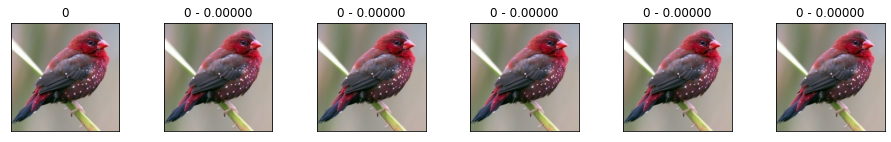

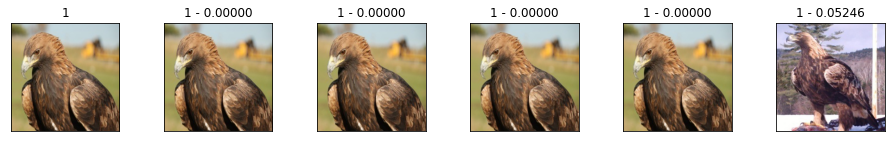

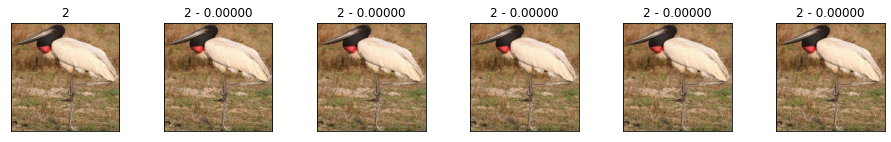

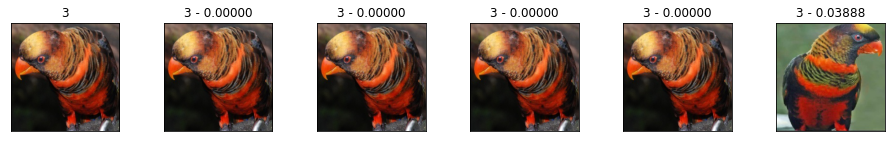

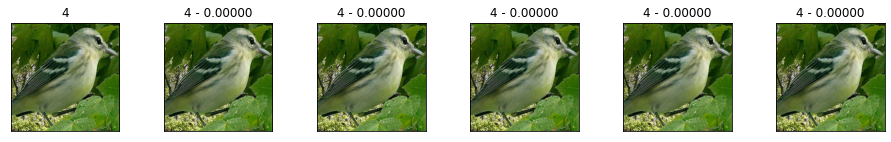

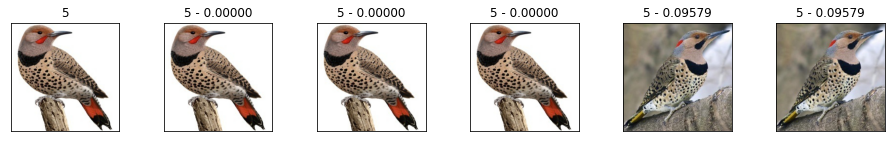

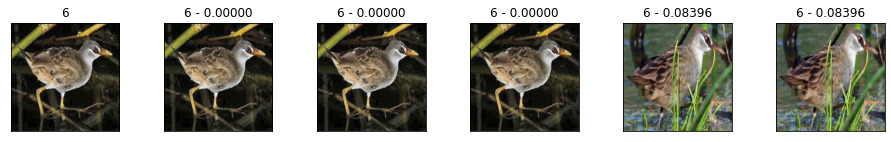

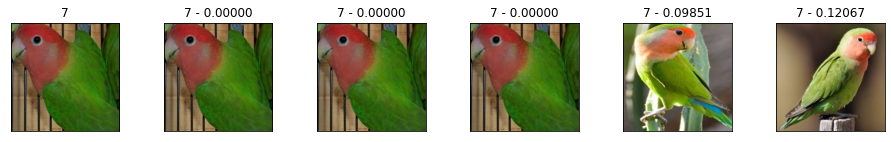

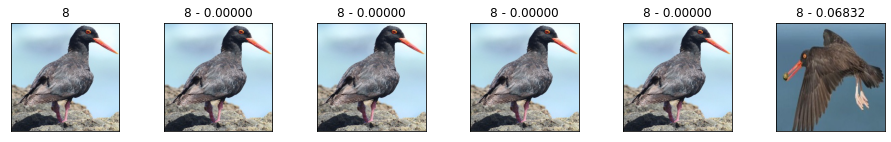

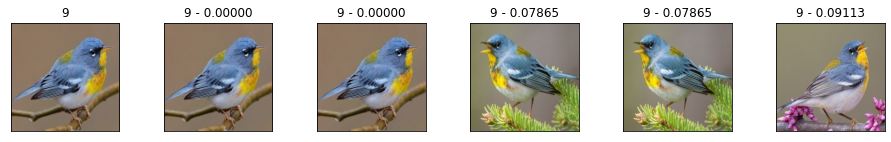

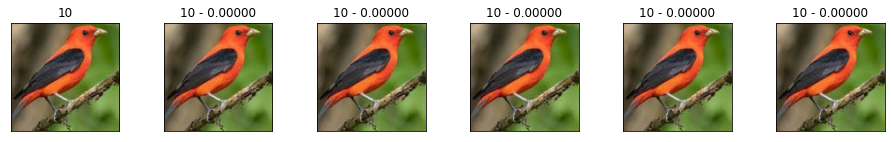

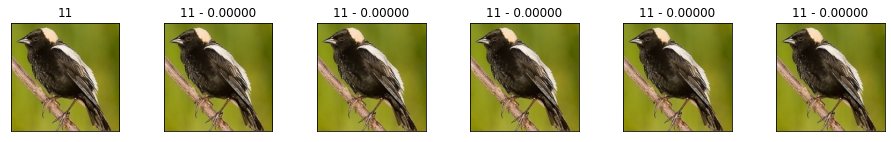

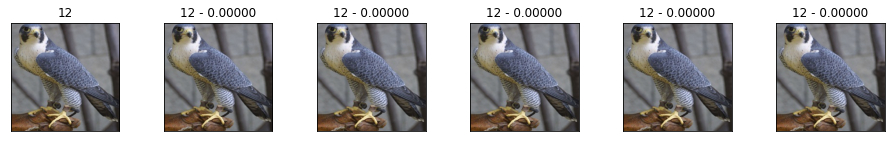

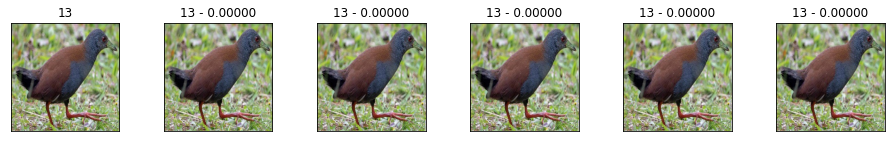

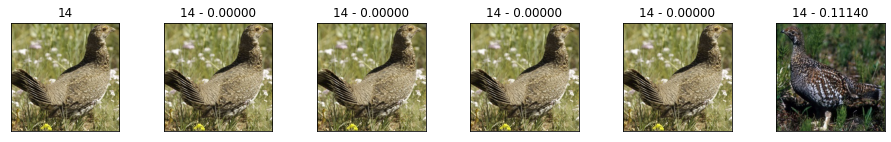

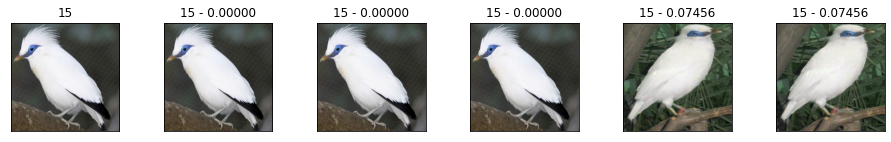

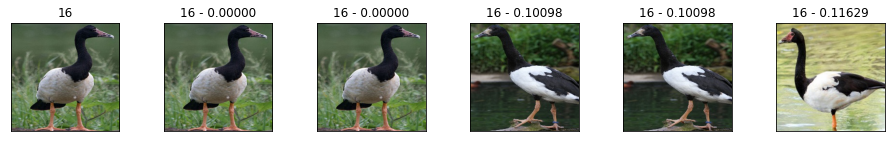

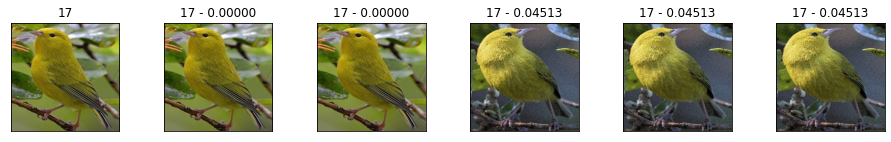

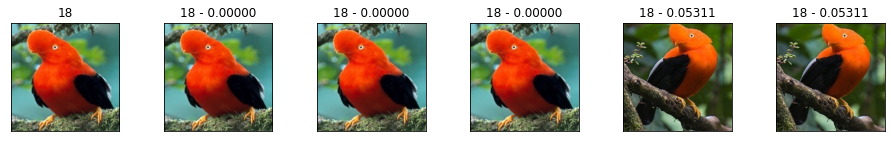

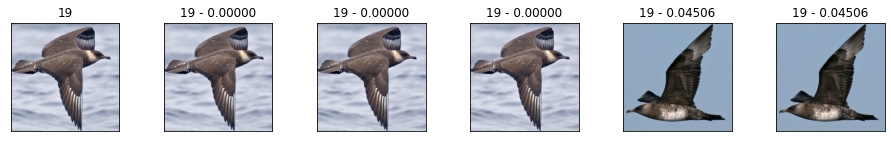

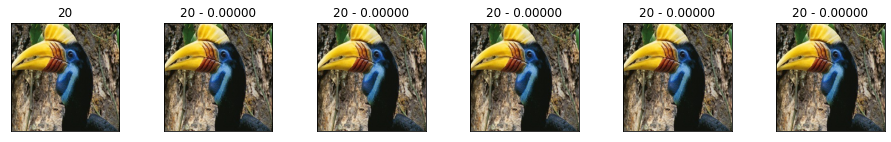

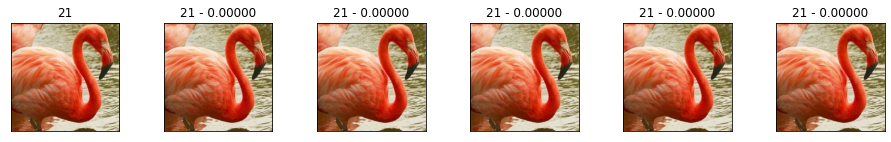

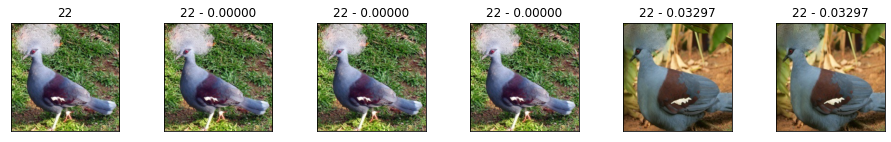

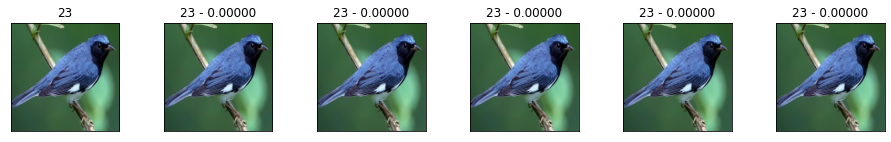

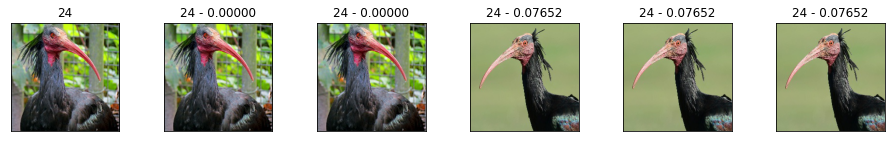

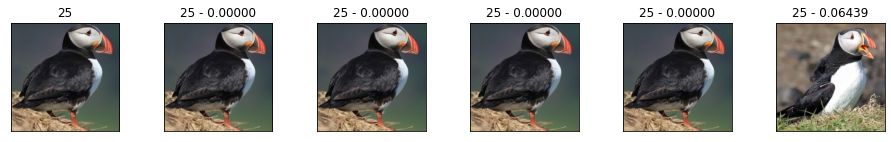

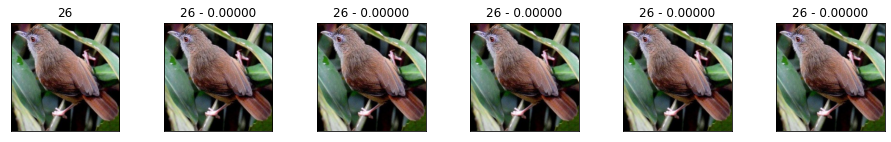

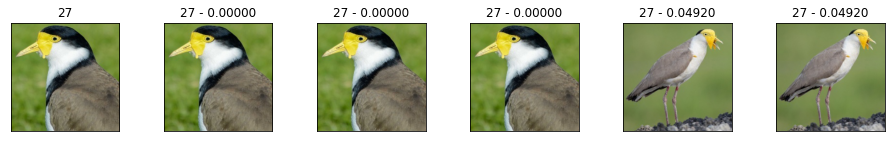

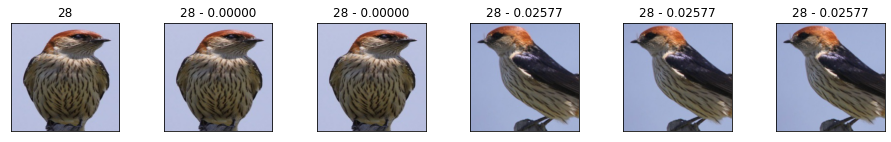

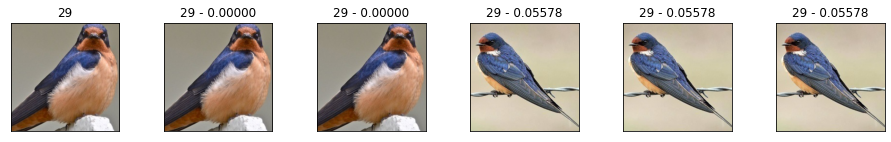

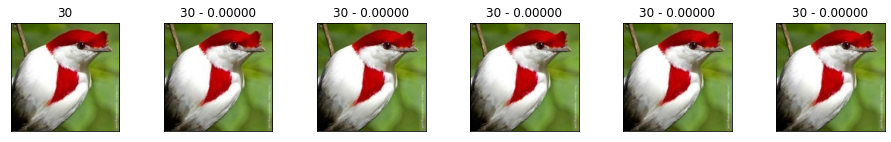

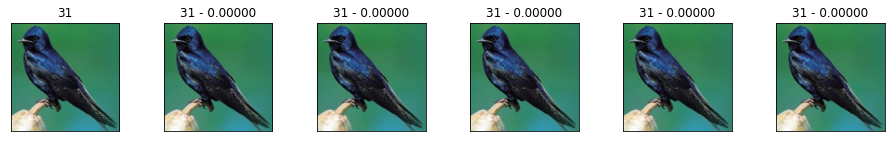

In [18]:
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(train_x, train_y, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

## Calibration

To be able to tell if an example matches a given class, we first need to `calibrate()` the model to find the optimal cut point. This cut point is the maximum distance below which returned neighbors are of the same class. Increasing the threshold improves the recall at the expense of the precision.

By default, the calibration uses the F-score classification metric to optimally balance out the precsion and recalll; however, you can speficy your own target and change the calibration metric to better suite your usecase.

In [29]:
# num_calibration_samples = 1  # @param {type:"integer"}
# calibration = model.calibrate(x=train_x,y=train_y)

ValueError: in user code:

    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/ufuk/anaconda3/envs/pythonProject/lib/python3.7/site-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "similarity_model" expects 1 input(s), but it received 2000 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:96' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:97' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:98' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:99' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:100' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:101' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:102' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:103' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:104' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:105' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:106' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:107' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:108' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:109' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:110' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:111' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:112' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:113' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:114' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:115' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:116' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:117' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:118' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:119' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:120' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:121' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:122' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:123' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:124' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:125' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:126' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:127' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:128' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:129' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:130' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:131' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:132' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:133' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:134' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:135' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:136' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:137' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:138' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:139' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:140' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:141' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:142' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:143' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:144' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:145' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:146' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:147' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:148' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:149' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:150' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:151' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:152' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:153' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:154' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:155' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:156' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:157' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:158' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:159' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:160' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:161' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:162' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:163' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:164' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:165' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:166' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:167' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:168' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:169' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:170' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:171' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:172' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:173' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:174' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:175' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:176' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:177' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:178' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:179' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:180' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:181' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:182' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:183' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:184' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:185' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:186' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:187' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:188' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:189' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:190' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:191' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:192' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:193' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:194' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:195' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:196' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:197' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:198' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:199' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:200' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:201' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:202' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:203' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:204' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:205' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:206' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:207' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:208' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:209' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:210' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:211' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:212' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:213' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:214' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:215' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:216' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:217' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:218' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:219' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:220' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:221' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:222' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:223' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:224' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:225' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:226' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:227' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:228' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:229' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:230' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:231' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:232' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:233' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:234' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:235' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:236' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:237' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:238' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:239' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:240' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:241' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:242' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:243' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:244' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:245' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:246' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:247' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:248' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:249' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:250' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:251' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:252' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:253' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:254' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:255' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:256' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:257' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:258' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:259' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:260' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:261' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:262' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:263' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:264' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:265' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:266' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:267' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:268' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:269' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:270' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:271' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:272' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:273' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:274' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:275' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:276' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:277' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:278' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:279' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:280' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:281' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:282' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:283' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:284' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:285' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:286' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:287' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:288' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:289' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:290' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:291' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:292' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:293' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:294' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:295' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:296' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:297' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:298' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:299' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:300' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:301' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:302' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:303' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:304' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:305' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:306' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:307' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:308' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:309' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:310' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:311' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:312' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:313' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:314' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:315' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:316' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:317' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:318' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:319' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:320' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:321' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:322' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:323' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:324' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:325' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:326' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:327' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:328' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:329' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:330' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:331' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:332' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:333' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:334' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:335' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:336' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:337' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:338' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:339' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:340' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:341' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:342' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:343' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:344' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:345' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:346' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:347' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:348' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:349' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:350' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:351' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:352' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:353' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:354' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:355' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:356' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:357' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:358' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:359' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:360' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:361' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:362' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:363' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:364' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:365' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:366' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:367' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:368' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:369' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:370' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:371' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:372' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:373' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:374' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:375' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:376' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:377' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:378' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:379' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:380' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:381' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:382' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:383' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:384' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:385' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:386' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:387' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:388' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:389' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:390' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:391' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:392' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:393' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:394' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:395' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:396' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:397' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:398' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:399' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:400' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:401' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:402' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:403' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:404' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:405' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:406' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:407' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:408' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:409' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:410' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:411' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:412' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:413' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:414' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:415' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:416' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:417' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:418' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:419' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:420' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:421' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:422' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:423' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:424' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:425' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:426' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:427' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:428' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:429' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:430' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:431' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:432' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:433' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:434' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:435' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:436' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:437' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:438' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:439' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:440' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:441' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:442' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:443' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:444' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:445' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:446' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:447' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:448' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:449' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:450' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:451' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:452' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:453' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:454' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:455' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:456' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:457' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:458' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:459' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:460' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:461' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:462' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:463' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:464' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:465' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:466' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:467' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:468' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:469' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:470' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:471' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:472' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:473' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:474' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:475' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:476' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:477' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:478' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:479' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:480' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:481' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:482' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:483' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:484' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:485' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:486' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:487' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:488' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:489' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:490' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:491' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:492' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:493' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:494' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:495' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:496' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:497' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:498' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:499' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:500' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:501' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:502' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:503' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:504' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:505' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:506' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:507' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:508' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:509' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:510' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:511' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:512' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:513' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:514' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:515' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:516' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:517' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:518' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:519' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:520' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:521' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:522' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:523' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:524' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:525' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:526' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:527' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:528' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:529' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:530' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:531' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:532' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:533' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:534' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:535' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:536' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:537' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:538' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:539' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:540' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:541' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:542' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:543' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:544' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:545' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:546' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:547' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:548' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:549' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:550' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:551' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:552' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:553' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:554' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:555' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:556' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:557' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:558' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:559' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:560' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:561' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:562' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:563' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:564' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:565' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:566' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:567' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:568' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:569' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:570' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:571' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:572' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:573' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:574' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:575' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:576' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:577' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:578' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:579' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:580' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:581' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:582' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:583' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:584' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:585' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:586' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:587' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:588' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:589' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:590' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:591' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:592' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:593' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:594' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:595' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:596' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:597' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:598' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:599' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:600' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:601' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:602' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:603' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:604' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:605' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:606' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:607' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:608' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:609' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:610' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:611' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:612' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:613' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:614' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:615' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:616' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:617' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:618' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:619' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:620' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:621' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:622' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:623' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:624' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:625' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:626' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:627' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:628' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:629' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:630' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:631' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:632' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:633' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:634' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:635' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:636' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:637' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:638' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:639' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:640' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:641' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:642' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:643' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:644' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:645' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:646' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:647' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:648' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:649' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:650' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:651' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:652' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:653' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:654' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:655' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:656' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:657' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:658' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:659' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:660' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:661' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:662' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:663' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:664' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:665' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:666' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:667' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:668' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:669' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:670' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:671' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:672' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:673' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:674' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:675' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:676' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:677' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:678' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:679' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:680' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:681' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:682' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:683' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:684' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:685' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:686' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:687' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:688' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:689' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:690' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:691' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:692' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:693' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:694' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:695' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:696' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:697' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:698' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:699' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:700' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:701' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:702' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:703' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:704' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:705' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:706' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:707' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:708' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:709' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:710' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:711' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:712' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:713' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:714' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:715' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:716' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:717' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:718' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:719' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:720' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:721' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:722' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:723' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:724' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:725' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:726' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:727' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:728' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:729' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:730' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:731' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:732' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:733' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:734' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:735' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:736' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:737' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:738' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:739' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:740' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:741' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:742' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:743' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:744' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:745' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:746' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:747' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:748' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:749' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:750' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:751' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:752' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:753' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:754' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:755' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:756' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:757' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:758' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:759' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:760' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:761' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:762' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:763' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:764' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:765' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:766' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:767' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:768' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:769' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:770' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:771' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:772' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:773' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:774' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:775' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:776' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:777' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:778' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:779' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:780' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:781' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:782' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:783' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:784' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:785' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:786' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:787' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:788' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:789' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:790' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:791' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:792' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:793' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:794' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:795' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:796' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:797' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:798' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:799' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:800' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:801' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:802' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:803' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:804' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:805' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:806' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:807' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:808' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:809' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:810' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:811' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:812' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:813' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:814' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:815' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:816' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:817' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:818' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:819' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:820' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:821' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:822' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:823' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:824' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:825' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:826' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:827' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:828' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:829' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:830' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:831' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:832' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:833' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:834' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:835' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:836' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:837' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:838' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:839' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:840' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:841' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:842' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:843' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:844' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:845' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:846' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:847' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:848' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:849' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:850' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:851' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:852' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:853' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:854' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:855' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:856' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:857' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:858' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:859' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:860' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:861' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:862' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:863' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:864' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:865' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:866' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:867' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:868' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:869' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:870' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:871' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:872' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:873' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:874' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:875' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:876' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:877' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:878' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:879' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:880' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:881' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:882' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:883' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:884' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:885' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:886' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:887' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:888' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:889' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:890' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:891' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:892' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:893' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:894' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:895' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:896' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:897' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:898' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:899' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:900' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:901' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:902' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:903' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:904' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:905' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:906' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:907' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:908' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:909' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:910' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:911' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:912' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:913' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:914' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:915' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:916' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:917' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:918' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:919' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:920' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:921' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:922' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:923' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:924' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:925' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:926' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:927' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:928' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:929' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:930' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:931' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:932' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:933' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:934' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:935' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:936' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:937' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:938' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:939' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:940' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:941' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:942' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:943' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:944' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:945' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:946' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:947' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:948' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:949' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:950' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:951' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:952' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:953' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:954' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:955' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:956' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:957' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:958' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:959' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:960' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:961' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:962' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:963' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:964' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:965' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:966' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:967' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:968' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:969' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:970' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:971' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:972' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:973' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:974' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:975' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:976' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:977' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:978' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:979' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:980' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:981' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:982' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:983' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:984' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:985' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:986' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:987' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:988' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:989' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:990' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:991' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:992' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:993' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:994' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:995' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:996' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:997' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:998' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:999' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1000' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1001' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1002' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1003' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1004' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1005' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1006' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1007' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1008' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1009' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1010' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1011' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1012' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1013' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1014' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1015' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1016' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1017' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1018' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1019' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1020' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1021' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1022' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1023' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1024' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1025' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1026' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1027' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1028' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1029' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1030' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1031' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1032' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1033' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1034' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1035' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1036' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1037' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1038' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1039' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1040' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1041' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1042' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1043' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1044' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1045' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1046' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1047' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1048' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1049' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1050' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1051' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1052' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1053' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1054' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1055' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1056' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1057' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1058' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1059' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1060' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1061' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1062' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1063' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1064' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1065' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1066' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1067' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1068' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1069' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1070' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1071' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1072' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1073' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1074' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1075' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1076' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1077' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1078' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1079' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1080' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1081' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1082' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1083' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1084' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1085' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1086' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1087' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1088' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1089' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1090' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1091' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1092' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1093' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1094' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1095' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1096' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1097' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1098' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1099' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1100' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1101' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1102' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1103' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1104' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1105' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1106' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1107' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1108' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1109' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1110' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1111' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1112' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1113' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1114' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1115' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1116' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1117' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1118' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1119' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1120' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1121' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1122' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1123' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1124' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1125' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1126' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1127' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1128' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1129' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1130' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1131' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1132' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1133' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1134' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1135' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1136' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1137' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1138' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1139' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1140' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1141' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1142' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1143' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1144' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1145' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1146' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1147' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1148' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1149' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1150' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1151' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1152' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1153' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1154' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1155' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1156' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1157' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1158' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1159' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1160' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1161' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1162' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1163' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1164' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1165' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1166' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1167' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1168' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1169' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1170' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1171' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1172' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1173' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1174' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1175' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1176' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1177' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1178' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1179' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1180' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1181' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1182' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1183' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1184' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1185' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1186' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1187' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1188' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1189' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1190' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1191' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1192' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1193' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1194' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1195' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1196' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1197' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1198' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1199' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1200' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1201' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1202' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1203' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1204' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1205' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1206' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1207' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1208' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1209' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1210' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1211' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1212' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1213' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1214' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1215' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1216' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1217' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1218' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1219' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1220' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1221' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1222' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1223' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1224' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1225' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1226' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1227' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1228' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1229' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1230' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1231' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1232' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1233' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1234' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1235' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1236' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1237' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1238' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1239' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1240' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1241' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1242' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1243' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1244' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1245' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1246' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1247' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1248' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1249' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1250' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1251' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1252' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1253' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1254' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1255' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1256' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1257' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1258' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1259' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1260' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1261' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1262' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1263' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1264' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1265' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1266' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1267' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1268' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1269' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1270' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1271' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1272' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1273' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1274' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1275' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1276' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1277' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1278' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1279' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1280' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1281' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1282' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1283' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1284' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1285' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1286' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1287' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1288' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1289' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1290' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1291' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1292' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1293' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1294' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1295' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1296' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1297' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1298' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1299' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1300' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1301' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1302' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1303' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1304' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1305' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1306' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1307' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1308' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1309' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1310' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1311' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1312' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1313' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1314' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1315' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1316' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1317' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1318' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1319' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1320' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1321' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1322' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1323' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1324' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1325' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1326' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1327' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1328' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1329' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1330' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1331' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1332' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1333' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1334' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1335' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1336' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1337' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1338' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1339' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1340' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1341' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1342' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1343' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1344' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1345' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1346' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1347' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1348' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1349' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1350' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1351' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1352' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1353' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1354' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1355' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1356' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1357' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1358' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1359' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1360' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1361' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1362' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1363' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1364' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1365' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1366' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1367' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1368' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1369' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1370' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1371' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1372' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1373' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1374' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1375' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1376' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1377' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1378' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1379' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1380' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1381' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1382' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1383' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1384' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1385' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1386' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1387' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1388' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1389' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1390' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1391' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1392' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1393' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1394' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1395' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1396' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1397' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1398' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1399' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1400' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1401' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1402' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1403' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1404' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1405' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1406' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1407' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1408' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1409' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1410' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1411' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1412' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1413' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1414' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1415' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1416' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1417' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1418' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1419' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1420' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1421' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1422' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1423' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1424' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1425' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1426' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1427' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1428' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1429' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1430' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1431' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1432' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1433' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1434' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1435' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1436' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1437' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1438' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1439' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1440' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1441' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1442' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1443' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1444' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1445' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1446' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1447' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1448' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1449' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1450' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1451' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1452' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1453' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1454' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1455' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1456' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1457' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1458' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1459' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1460' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1461' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1462' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1463' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1464' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1465' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1466' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1467' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1468' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1469' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1470' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1471' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1472' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1473' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1474' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1475' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1476' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1477' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1478' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1479' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1480' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1481' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1482' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1483' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1484' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1485' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1486' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1487' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1488' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1489' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1490' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1491' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1492' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1493' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1494' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1495' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1496' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1497' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1498' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1499' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1500' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1501' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1502' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1503' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1504' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1505' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1506' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1507' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1508' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1509' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1510' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1511' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1512' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1513' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1514' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1515' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1516' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1517' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1518' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1519' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1520' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1521' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1522' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1523' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1524' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1525' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1526' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1527' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1528' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1529' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1530' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1531' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1532' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1533' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1534' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1535' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1536' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1537' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1538' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1539' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1540' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1541' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1542' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1543' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1544' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1545' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1546' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1547' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1548' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1549' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1550' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1551' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1552' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1553' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1554' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1555' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1556' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1557' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1558' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1559' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1560' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1561' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1562' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1563' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1564' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1565' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1566' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1567' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1568' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1569' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1570' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1571' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1572' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1573' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1574' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1575' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1576' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1577' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1578' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1579' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1580' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1581' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1582' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1583' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1584' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1585' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1586' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1587' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1588' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1589' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1590' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1591' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1592' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1593' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1594' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1595' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1596' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1597' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1598' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1599' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1600' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1601' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1602' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1603' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1604' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1605' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1606' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1607' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1608' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1609' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1610' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1611' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1612' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1613' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1614' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1615' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1616' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1617' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1618' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1619' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1620' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1621' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1622' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1623' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1624' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1625' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1626' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1627' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1628' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1629' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1630' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1631' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1632' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1633' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1634' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1635' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1636' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1637' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1638' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1639' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1640' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1641' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1642' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1643' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1644' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1645' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1646' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1647' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1648' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1649' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1650' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1651' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1652' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1653' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1654' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1655' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1656' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1657' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1658' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1659' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1660' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1661' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1662' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1663' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1664' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1665' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1666' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1667' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1668' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1669' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1670' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1671' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1672' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1673' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1674' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1675' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1676' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1677' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1678' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1679' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1680' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1681' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1682' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1683' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1684' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1685' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1686' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1687' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1688' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1689' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1690' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1691' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1692' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1693' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1694' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1695' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1696' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1697' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1698' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1699' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1700' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1701' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1702' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1703' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1704' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1705' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1706' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1707' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1708' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1709' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1710' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1711' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1712' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1713' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1714' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1715' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1716' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1717' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1718' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1719' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1720' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1721' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1722' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1723' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1724' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1725' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1726' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1727' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1728' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1729' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1730' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1731' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1732' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1733' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1734' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1735' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1736' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1737' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1738' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1739' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1740' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1741' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1742' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1743' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1744' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1745' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1746' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1747' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1748' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1749' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1750' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1751' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1752' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1753' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1754' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1755' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1756' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1757' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1758' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1759' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1760' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1761' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1762' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1763' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1764' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1765' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1766' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1767' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1768' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1769' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1770' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1771' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1772' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1773' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1774' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1775' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1776' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1777' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1778' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1779' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1780' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1781' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1782' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1783' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1784' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1785' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1786' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1787' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1788' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1789' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1790' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1791' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1792' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1793' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1794' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1795' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1796' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1797' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1798' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1799' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1800' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1801' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1802' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1803' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1804' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1805' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1806' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1807' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1808' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1809' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1810' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1811' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1812' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1813' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1814' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1815' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1816' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1817' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1818' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1819' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1820' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1821' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1822' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1823' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1824' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1825' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1826' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1827' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1828' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1829' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1830' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1831' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1832' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1833' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1834' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1835' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1836' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1837' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1838' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1839' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1840' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1841' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1842' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1843' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1844' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1845' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1846' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1847' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1848' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1849' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1850' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1851' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1852' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1853' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1854' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1855' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1856' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1857' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1858' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1859' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1860' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1861' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1862' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1863' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1864' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1865' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1866' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1867' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1868' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1869' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1870' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1871' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1872' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1873' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1874' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1875' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1876' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1877' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1878' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1879' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1880' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1881' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1882' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1883' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1884' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1885' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1886' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1887' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1888' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1889' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1890' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1891' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1892' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1893' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1894' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1895' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1896' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1897' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1898' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1899' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1900' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1901' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1902' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1903' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1904' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1905' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1906' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1907' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1908' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1909' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1910' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1911' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1912' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1913' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1914' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1915' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1916' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1917' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1918' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1919' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1920' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1921' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1922' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1923' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1924' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1925' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1926' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1927' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1928' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1929' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1930' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1931' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1932' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1933' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1934' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1935' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1936' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1937' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1938' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1939' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1940' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1941' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1942' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1943' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1944' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1945' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1946' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1947' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1948' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1949' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1950' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1951' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1952' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1953' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1954' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1955' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1956' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1957' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1958' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1959' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1960' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1961' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1962' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1963' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1964' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1965' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1966' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1967' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1968' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1969' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1970' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1971' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1972' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1973' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1974' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1975' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1976' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1977' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1978' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1979' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1980' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1981' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1982' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1983' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1984' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1985' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1986' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1987' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1988' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1989' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1990' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1991' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1992' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1993' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1994' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1995' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1996' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1997' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1998' shape=(32, 224, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1999' shape=(32, 224, 3) dtype=uint8>]


## Metrics ploting

Let's plot the performance metrics to see how they evolve as the distance threshold increases. 

We clearly see an inflection point where the precision and recall intersect, however, this is not the `optimal_cutpoint` because the recall continues to increase faster than the precision decreases. Different usecases will have different performance profiles, which why each model needs to be calibrated.

In [ ]:
# fig, ax = plt.subplots()
# x = calibration.thresholds["distance"]
# ax.plot(x, calibration.thresholds["precision"], label="precision")
# ax.plot(x, calibration.thresholds["recall"], label="recall")
# ax.plot(x, calibration.thresholds["f1"], label="f1 score")
# ax.legend()
# ax.set_title("Metric evolution as distance increase")
# ax.set_xlabel("Distance")
# plt.show()

### Precision/Recall curve

We can see in the precision/recall curve below, that the curve is not smooth.
This is because the recall can improve independently of the precision causing a 
seesaw pattern.

Additionally, the model does extremly well on known classes and less well on 
the unseen ones, which contributes to the flat curve at the begining followed 
by a sharp decline as the distance threshold increases and 
examples are further away from the indexed examples.

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
# ax.set_title("Precision recall curve")
# ax.set_xlabel("Recall")
# ax.set_ylabel("Precision")
# plt.show()

## Matching

The purpose of `match()` is to allow you to use your similarity models to make 
classification predictions. It accomplishes this by finding the nearest neigbors
for a set of query examples and returning an infered label based on neighbors 
labels and the matching strategy used (MatchNearest by default).

Note: unlike traditional models, the  `match()` method potentially returns -1 
when there are no indexed examples below the cutpoint threshold. The -1 class
should be treated as "unknown".

### Matching in practice
Let's now match a 10 examples to see how you can use the model `match()` method 
in practice. 

In [30]:
num_matches = 10  # @param {type:"integer"}

matches = model.match(valid_x[:num_matches], cutpoint="optimal")
rows = []
for idx, match in enumerate(matches):
    rows.append([match, valid_y[idx], match == valid_y[idx]])
print(tabulate(rows, headers=["Predicted", "Expected", "Correct"]))

ValueError: Uncalibrated model: run model.calibration()

### confusion matrix
Now that we have a better sense of what the match() method does, let's scale up 
to a few thousand samples per class and evaluate how good our model is at 
predicting the correct classes.

As expected, while the model prediction performance is very good, its not 
competitive with a classification model. However this lower accuracy comes with 
the unique advantage that the model is able to classify classes 
that were not seen during training.


**NOTE** `tf.math.confusion_matrix` doesn't support negative classes, so we are going to use **class 10 as our unknown class**. As mentioned earlier, unknown examples are 
any testing example for which the closest neighbor distance is greater than the cutpoint threshold.

In [ ]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]
num_examples_per_class = 1000
cutpoint = "optimal"

x_confusion, y_confusion = tfsim.samplers.select_examples(valid_x, valid_y, CLASSES, num_examples_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusin matrix for cutpoint:%s" % cutpoint,
)

## Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [ ]:
model.index_summary()

## Saving and reloading
Saving and reloading the model works as you would expected: 

- `model.save(path, save_index=True)`: save the model and the index on disk. By default the index is compressed but this can be disabled by setting `compressed=False`

- `model = tf.keras.model.load_model(path, custom_objects={"SimilarityModel": tfsim.models.SimilarityModel})` reload the model. 

- **NOTE**: We need to pass `SimilarityModel` as a custom object to ensure that Keras knows about the index methods.

- `model.load_index(path)` Is requried to reload the index. 

- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index independently of saving/loading a model.


### Saving

In [ ]:
# save the model and the index
save_path = "models/hello_world"  # @param {type:"string"}
model.save(save_path, save_index=True)

### Reloading

In [ ]:
# reload the model
reloaded_model = tf.keras.models.load_model(
    save_path,
    custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)
# reload the index
reloaded_model.load_index(save_path)

In [ ]:
# check the index is back
reloaded_model.index_summary()

## Query reloaded model
Querying the reloaded model with its reload index works as expected

In [ ]:
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(valid_x, valid_y, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

Thanks you for following this tutorial till the end. If you are interested in learning about TensorFlow Similarity advanced features, you can checkout our other notebooks.